Importing Required Libraries

In [1]:
import os # For working with files
import numpy as np # for numerical computations
import pandas as pd #for working with dataframes
import torch # PyTorch Module
import matplotlib.pyplot as plt # for plotting informations on graphs
import torch.nn as nn # for creating neural networks
from torch.utils.data import DataLoader # for DataLoaders
from PIL import Image #for checking images
import torch.nn.functional as F #for functions for calculating loss
from torchvision.transforms import transforms # for transforming images to tensors
from torchvision.datasets import ImageFolder # for working with classes and images
from torchvision.utils import make_grid # for data checking
from torchsummary import summary #for getting summary of our model 
%matplotlib inline


Exploring the Data

In [8]:
data_dir = "../input/plants/plants"
train_dir = data_dir+"/train"
valid_dir = data_dir+"/valid"
diseases = os.listdir(train_dir)
print(diseases)

1099

In [9]:
print("Total disease classes are: {}".format(len(diseases)))

30

In [10]:
plants = []
numberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        numberOfDiseases += 1

In [11]:
print("Unique plants are \n{}\nTotal:{}".format(plants,len(plants)))

206

In [12]:
print("Number of diseases: {}".format(numberOfDiseases))

23

In [14]:
# Number of Images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir+'/'+disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

2575

Plotting number of images available for each disease


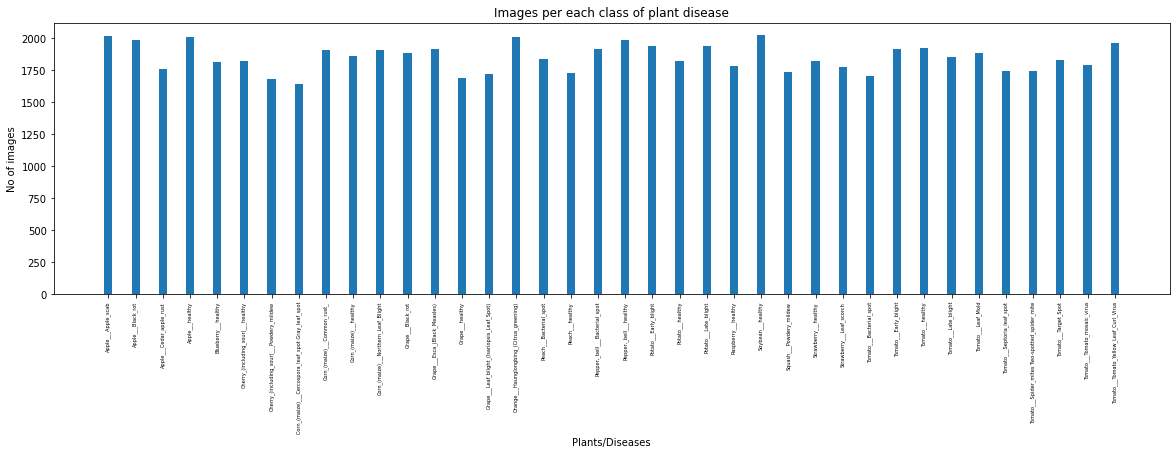

In [15]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index , [n for n in nums.values()] ,width=0.3)
plt.xlabel("Plants/Diseases", fontsize=10)
plt.ylabel('No of images', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title("Images per each class of plant disease")
plt.savefig('../app/static/my_images/models/Images_per_Disease.png')

Images available for training

In [16]:
n_train = 0
for value in nums.values():
    n_train+=value
print(" There are {} images for training".format(n_train))

37

Preparing Data for Training

In [17]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

After loading the images, we need to transform the pixel of each image (0-255) to 0-1 as neural networks works best with normalized data.

In [18]:
len(train.classes)


38

In [19]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label : "+train.classes[label] + "("+ str(label)+")" )
    plt.imshow(image.permute(1, 2, 0))

Label : Apple___Apple_scab(0)


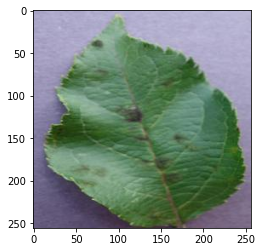

In [20]:
show_image(*train[0])

In [21]:
random_seed = 7
torch.manual_seed(random_seed)

In [22]:
batch_size = 8

In [23]:
#Data loaders for training and validating
train_dl = DataLoader(train, batch_size,shuffle=True, num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=8, pin_memory=True)

<b>DataLoader</b> helps in loading large and memory consuming datasets.<br>
<i>num_workers</i> denote the number of processes that generate batches in parallel

In [24]:
# hrlper function to show batch of training instanses
def show_batch(data):
    for images,labels in data:
        fig, ax = plt.subplots(figsize=(30,30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break

In [ ]:
# show_batch(train_dl)

<h1>Modelling</h1>
<p> It is recommended to use GPU instead of CPU while dealing with images datasets.</p>

In [25]:
# for moving data to GPU (if available)
def get_default_device():
    """Pick GPU if Available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")
    
# move data to device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device,non_blocking=True)

# for loading in the device
class DeviceDataLoader():
    """Wrap dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device""" 
        for b in self.dl:
            yield to_device(b,self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking device we are working

In [27]:
device = get_default_device()
device

5

Wrap our training and validation data loaders using <code>DeviceDataLoader</code> for automatically transferring batches of data to GPU

In [28]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl, device)

<h2> Building the model architecture </h2>

<h4>We are using <code><i>ResNet</i></code> architecture</h4>
<p>In <code><i>ResNet</i></code>, each layer feeds into next layer, we use a network with residual blocks, each layer feeds into the next layer and directly into layers 2-3 hops away. This avaids <b>over-fitting</b>. </p>

<h3>Residual Block code implementation</h3>

In [29]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out =self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 
        #ReLU can be applied before or after adding the input
    


<h4><b> Our <code>ImageClassificationBase</code> class has following functions: </b></h4>
<ul>
<li> <h5>training_step</h5> - To figure out how "wrong" the model is going after training or validation step. </li>
<li> <h5>validation_step</h5> - Accuracy in this case would be measured by threshold and counted if the difference between the model's prediction and the actual label is lower then threahold.</li>
<li> <h5>validation_epoch_end</h5> - We want tp track the validation losses/accuracies and train losses after each epoch </li>
<li> <h5>epoch_end</h5> - Print the validation losses/accuracies, train losses and learning rate </li>
</ul>

In [30]:
# for calculating accuracy
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    print(f'Progress: [{arrow}{padding}] ({str(current)} of {str(total)} {int(fraction*100)}%', end=ending)

In [31]:
# base class for model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        
        return {"val_loss":loss.detach(), "val_accuracy":acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {
            "val_loss":epoch_loss,
            "val_accuracy":epoch_accuracy
        }
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], last_lr : {:.5f}, train_loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.4f} "
        .format(epoch,result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']  ))

<h3> Defining the final architecture of the model </h3>

In [32]:
# Architecture for training

#colvolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels,out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    ]
    if pool : 
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# resNet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels,64)
        self.conv2 = ConvBlock(64, 128, pool=True) #out dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128,128) , ConvBlock(128,128))

        self.conv3 = ConvBlock(128,256,pool=True) #out dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) #out dim : 512 x 4 x 4
        self.res2 = nn.Sequential(ConvBlock(512,512), ConvBlock(512,512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                            nn.Flatten(),
                            nn.Linear(512, num_diseases))
    
    def forward(self, xb): #xb is loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


Define model object and transfer it into the device

In [33]:

model = to_device(ResNet9(3, len(train.classes)), device)
model.share_memory()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:

# #getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

5

<h2>Training the Model</h2>

<p>
    Before training lets define <code>evaluate</code> function. It will perform the validation phase.<br>
    A <code>fir_one_cycle()</code> will perform the entire training process. Some technique used are
<p>
<ul> 
    <li> <h5>Learning Rate Scheduling</h5> 
        - Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the leaning rate after every batch of training. We will use <code>One Cycle Learning Rate Policy</code> which involve starting with low learning rate, gradually increase it batch by batch to high learning rate for about 30% of epochs, then gradually decrease it to a very low value for remaining epochs. 
    </li><br><br>
    <li> <h5> Weight Decay </h5> 
        - Regularization technique which prevents the weight from becoming too large by adding an additional term to loss function  
    </li><br><br>
    <li> <h5> Gradient Clipping </h5>
        - Limit the values of gradients to small range to prevent undesirable changes in parameters due to large gradient values.
        </li>
</ul>
         

    
</p>

In [36]:
# for training
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    print("Evaluating...")
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fir_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    
    print("Begining...")
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    #scheduler for one cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        print("Running epoch {} out of {}".format(epoch,(epochs)))
        #Training
        model.train()
        train_losses = []
        lrs = []
        i=0
        for batch in train_loader:
            # progress_bar(i,range(train_loader))
            progress_bar(i ,len(train_loader))
            i+=1
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            #recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
        
        #validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [37]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [38]:
%%time
history = []
history += fir_OneCycle(epochs,max_lr, model, train_dl, valid_dl,
        grad_clip=grad_clip,
        weight_decay=weight_decay,
        opt_func=opt_func)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:

history

<h1> Plotting </h1>

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs no. of epochs')
    plt.savefig('../app/static/my_images/models/accuracyGraph_v2.png')

def plot_losses(history):
    
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x.get('val_loss').cpu() for x in history]
    
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title("Loss vs epoch Graph")
    plt.savefig('../app/static/my_images/models/lossGraph_v2.png')

def plot_lr(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    
    plt.plot(lrs)
    plt.xlabel('Batch No')
    plt.ylabel("Learning rate")
    plt.title("Learning rate vs Batch number")
    plt.savefig('../app/static/my_images/models/learningRateGraph_v2.png')

</h2>Validation Accuracy</h2>

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
plot_lr(history)

<h1> Testing the model on test data</h1>

In [ ]:
test_dir = "../input/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir+"/test"))
test_images

In [ ]:
def predict_image(img, model):
    #Convert to batch of 1
    xb = to_device(img.unsqueeze(0), device)

    # Get prediction from model
    yb = model(xb)

    _,preds = torch.max(yb,dim=1)
    return train.classes[preds[0].item()]

In [ ]:
#Predicting the first image
img, label = test[0]
plt.imshow(img.permute(1,2,0))
print('Label : '+test_images[0], 'Predicted: '+predict_image(img,model))

In [ ]:
for i, (img, lebel) in enumerate(test):
    print('Label : '+test_images[i], '\n Predicted: '+predict_image(img,model))
    print("#######################################################################")

<h1>Saving the model</h1>

<h3>Save/Load state_dict (Recommended)</h3>
<p>When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s state_dict with the <code>torch.save()</code> function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.</p>

<p>A common PyTorch convention is to save models using either a <code>.pt or .pth </code> file extension.</p>

Remember that you must call <code>model.eval()</code> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
PATH = '../models/plant-disease-model_v2.pth'
torch.save(model.state_dict(), PATH)